## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
import warnings
warnings.simplefilter( action="ignore", category=FutureWarning)

In [3]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [4]:
# set paths to directories for data and figures
fig_path = "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/out_figs/"

## **Read in count downsampled and processed whole tissue data**

In [5]:
# read in downsampled count matrices post whole-tissue clustering
wt_adata = sc.read( "../data/post-gaba-wt-dev-traj.h5ad")

In [6]:
# set CPM downsampled counts to anndata X
wt_adata.X = wt_adata.layers['ds_norm_cts'].copy()

## **Read in count downsampled and processed GABA inhibitory neuron data**

In [7]:
# read in downsampled count matrices post whole-tissue clustering
adata = sc.read( "../data/post-gaba-clustering.h5ad")

In [8]:
# set order of mature clusters and trajectories for visualization
mat_order = ['L2_CUX2_LAMP5', 'L3_CUX2_PRSS12',
             'L4_RORB_MET', 'L4_RORB_MME', 'L4_RORB_LRRK1', 
             'L5-6_THEMIS_CNR1', 'L5-6_THEMIS_NTNG2', 
             'L5-6_TLE4_HTR2C', 'L5-6_TLE4_SCUBE1', 'L5-6_TLE4_SORCS1',
             'LAMP5_NOS1', 'LAMP5_CCK', 'LAMP5_NDNF', 
             'CCK_RELN', 'CCK_SORCS1', 'CCK_SYT6', 'ID2_CSMD1',
             'VIP_ABI3BP', 'VIP_ADAMTSL1', 'VIP_CHRM2', 'VIP_CRH',
             'VIP_DPP6', 'VIP_HS3ST3A1', 'VIP_KIRREL3', 'VIP_PCDH20',
             'PV_SCUBE3', 'PV_SULF1', 'PV_WFDC2', 'PV_SST', 
             'SST_ADGRG6', 'SST_B3GAT2', 'SST_BRINP3', 'SST_CALB1', 
             'SST_NPY', 'SST_STK32A', 'SST_TH',
             'Astro_GFAP', 'Astro_SLC1A2',
             'OPC', 'OPC_MBP', 'Oligo']
#              , 'Micro', 'Vas_CLDN5', 'Vas_PDGFRB', 'Vas_TBX18']
dev_trajs = [ii for ii in wt_adata.obs_keys() if ii.split('_dev')[0] in mat_order]

In [9]:
# set age order for plotting
age_order_inds = np.unique( wt_adata.uns['age_order'], return_index=True)[1]
age_order = [wt_adata.uns['age_order'][index] for index in sorted(age_order_inds)]

In [10]:
# have to correct olig naming from having too many similar clusters
wt_adata.obs["sub_clust"] = wt_adata.obs['sub_clust'].astype(str)
olig_list = [ii for ii in wt_adata.obs['sub_clust'].unique() if 'Oligo' in ii]
wt_adata.obs.loc[wt_adata.obs["sub_clust"].isin( olig_list),'sub_clust'] = 'Oligo'

### Remove 40yr to reduce possible effects from aging 

In [11]:
wt_adata = wt_adata[wt_adata.obs['age']!='40yr']
adata = adata[adata.obs['age']!='40yr']
# high_adata = high_adata[high_adata.obs['age']!='40yr']
age_order = age_order[:-1]

## **Nearest Neighbors**

In [12]:
nn = 25
# high_adata = adata[:,adata.var.highly_variable.values]
# GABA neighbors
sc.pp.neighbors( adata, n_neighbors=nn, n_pcs=303, random_state=2)
# whole tissue neighbors
sc.pp.neighbors( wt_adata, n_neighbors=nn, n_pcs=365, random_state=2)

## **Proportion of adult neighbors at each age**

In [13]:
# function to approx normalize adult nuclei for testing purposes only
def get_rand_ref_mk( ref_mk, threshold=50):
    true_cts = sum( ref_mk)
    rand_ref_mk = ref_mk.copy()
    while true_cts>threshold:
        for itr, rr in enumerate(rand_ref_mk):
            if (rr==True) and (np.random.choice( [True,False], p=[0.25,0.75])):
                rr = False
            rand_ref_mk[itr] = rr 
        true_cts = sum( rand_ref_mk)
    return( rand_ref_mk)

In [14]:
tot_nn_df = pd.DataFrame( [], columns=age_order, dtype=int)

wt_df = wt_adata.obs.copy()
# in_df = adata.obs.copy()
in_df = wt_adata.obs.loc[adata.obs.index].copy()

for dev_itr in dev_trajs[:]:
    # common label for cluster
    mat_id = dev_itr.split('_dev')[0]
    # get cell type of cluster to match to correct anndata object
    cell_type = wt_df.loc[wt_df['sub_clust']==mat_id,'cell_type'].values[0]
    # if cell type is IN use adata
    if cell_type=='IN':
        dev_mk = in_df[dev_itr]=='dev-traj'
        # distance matrix where nonzero entries along rows give NNs
        dev_adata = adata[dev_mk]
    # use wt_adata for all other cell types
    else:
        dev_mk = wt_df[dev_itr]=='dev-traj'
        # distance matrix where nonzero entries along rows give NNs
        dev_adata = wt_adata[dev_mk]
    # get weighted adj matrix from umap
    dev_adj = dev_adata.obsp['distances'].copy()
    # mask for nuc of interst in dev-traj, here Adult
    ref_mk = (dev_adata.obs['stage_id']=='Adult').values
    
    # check for small adult populations
    if sum(ref_mk)<30:
        print( mat_id, "Does NOT contain enough adult nuclei")
        continue
        
#     ################################################
#     ################################################
#     # used to control for number of adult nucs in each traj, used to look for bias in sample size
#     ref_mk = get_rand_ref_mk( ref_mk, threshold=30)
#     ################################################
#     ################################################
    
    # mask adj to only include ref columns 
    ref_adj = dev_adj[:,ref_mk].copy()
    # create bool list for ref NN hits
    ref_hit_mk = np.array( [True]*sum(ref_mk))
    # get neighbors for nucs at each age
    tot = 0
    tot_mk = np.array( [False]*sum(ref_mk))
    for a_itr in age_order:
        ### get NN of age to adult
        # row mask adj by age
        s_mk = (dev_adata.obs['age']==a_itr).values
        s_adj = ref_adj[s_mk].copy()
        ### get NN of adult to age
        age_adj = dev_adj[:,s_mk].copy()
        ar_adj = age_adj[ref_mk].copy()
        ### total hits for age, all connections
        nn_hits = (s_adj>0).sum() + (ar_adj>0).sum()
        
        if nn_hits==0:
            tot_nn_df.loc[f"{mat_id}",a_itr] = 0
        else:
            tot_nn_df.loc[f"{mat_id}",a_itr] = nn_hits / (sum(s_mk) * sum(ref_mk))
#     print( mat_id)        

CCK_SYT6 Does NOT contain enough adult nuclei
SST_BRINP3 Does NOT contain enough adult nuclei
SST_NPY Does NOT contain enough adult nuclei
SST_TH Does NOT contain enough adult nuclei
VIP_PCDH20 Does NOT contain enough adult nuclei


## **Cumulative Sum of proportion of adult neighbors at each age**

In [15]:
plot_mat_order = np.array( mat_order)[np.in1d( mat_order, tot_nn_df.index)]
color_dict = wt_adata.uns['major_clust_colors_dict']

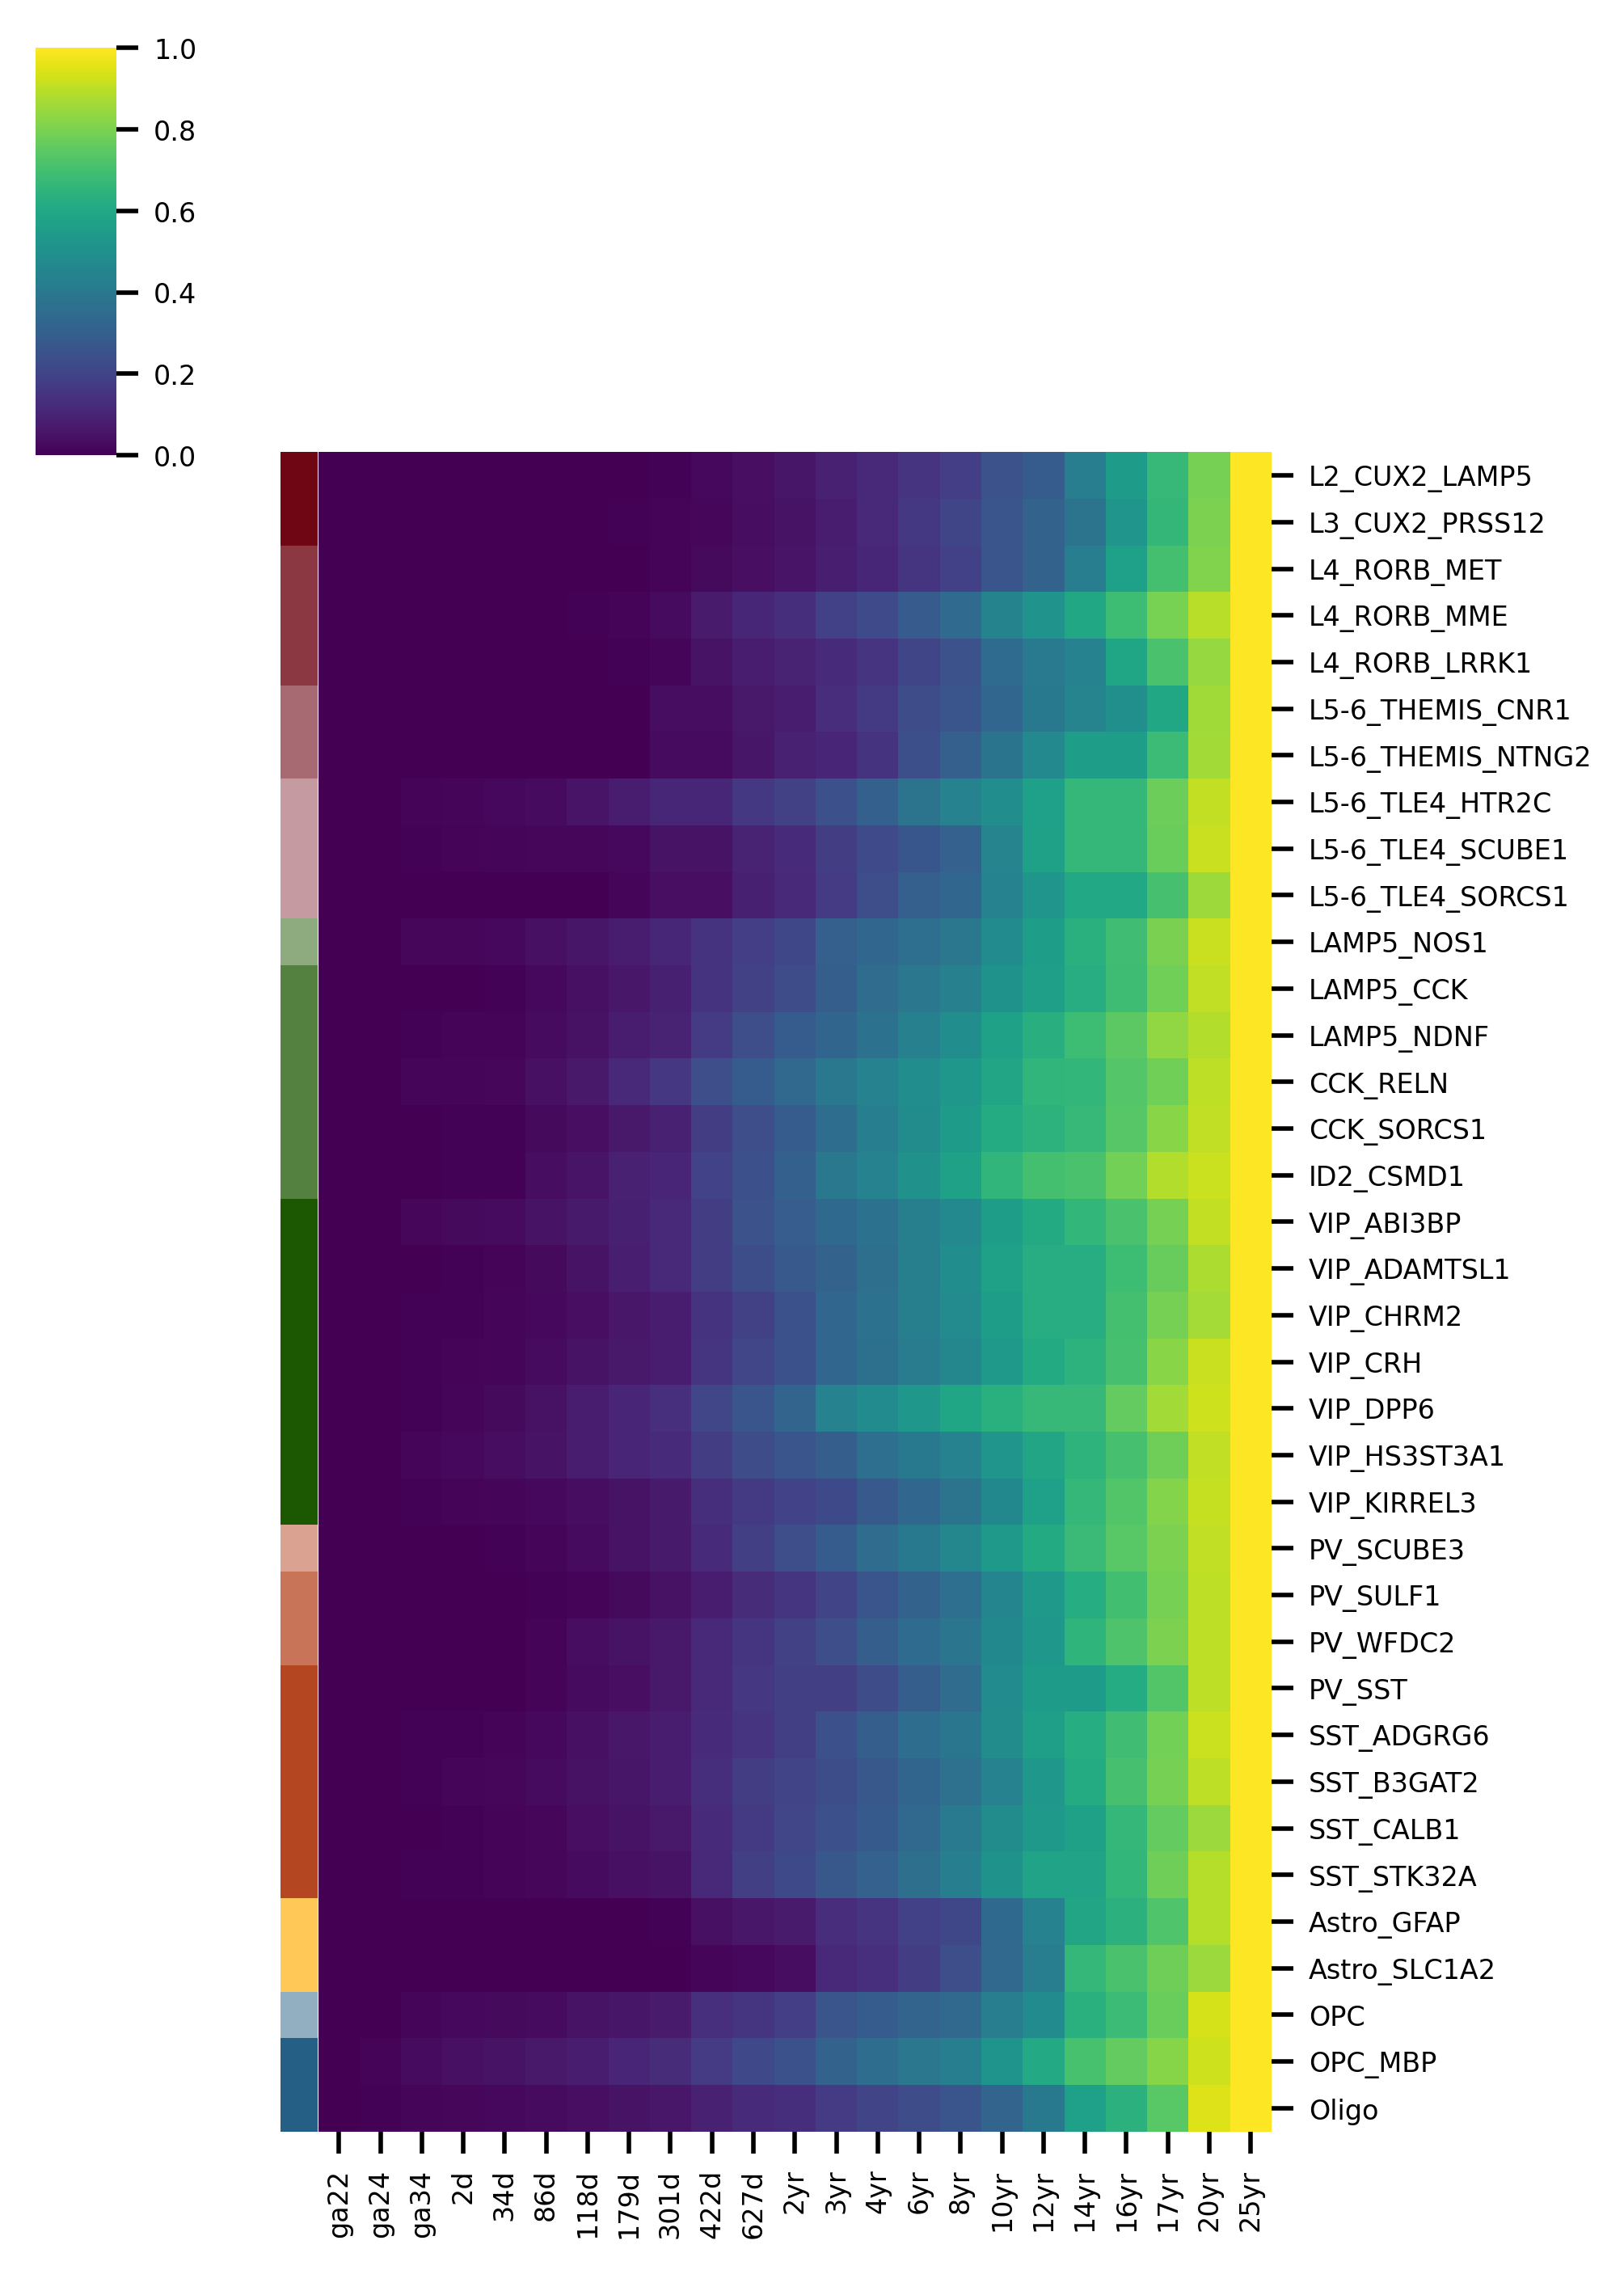

In [16]:
sc.settings.set_figure_params( dpi=200, fontsize=6)
# col_cc = [wt_adata.uns['stage_colors_dict'][ii] for ii in wt_adta.uns['stage_order']]
row_cc = [color_dict[wt_df.loc[wt_df['sub_clust']==ii,'major_clust'].values[0]] for ii in plot_mat_order[:]]

g = sns.clustermap( np.cumsum( tot_nn_df.loc[plot_mat_order[:]], axis=1), cmap='viridis', linewidths=0.0, linecolor="grey", figsize=(5,7), 
                   row_cluster=False, col_cluster=False, standard_scale=0, row_colors=row_cc)#, col_colors=col_cc)
fig = g.fig
fig.savefig( f"{fig_path}Nearest-Neighbor_Maturation.svg", format='svg', bbox_inches='tight')

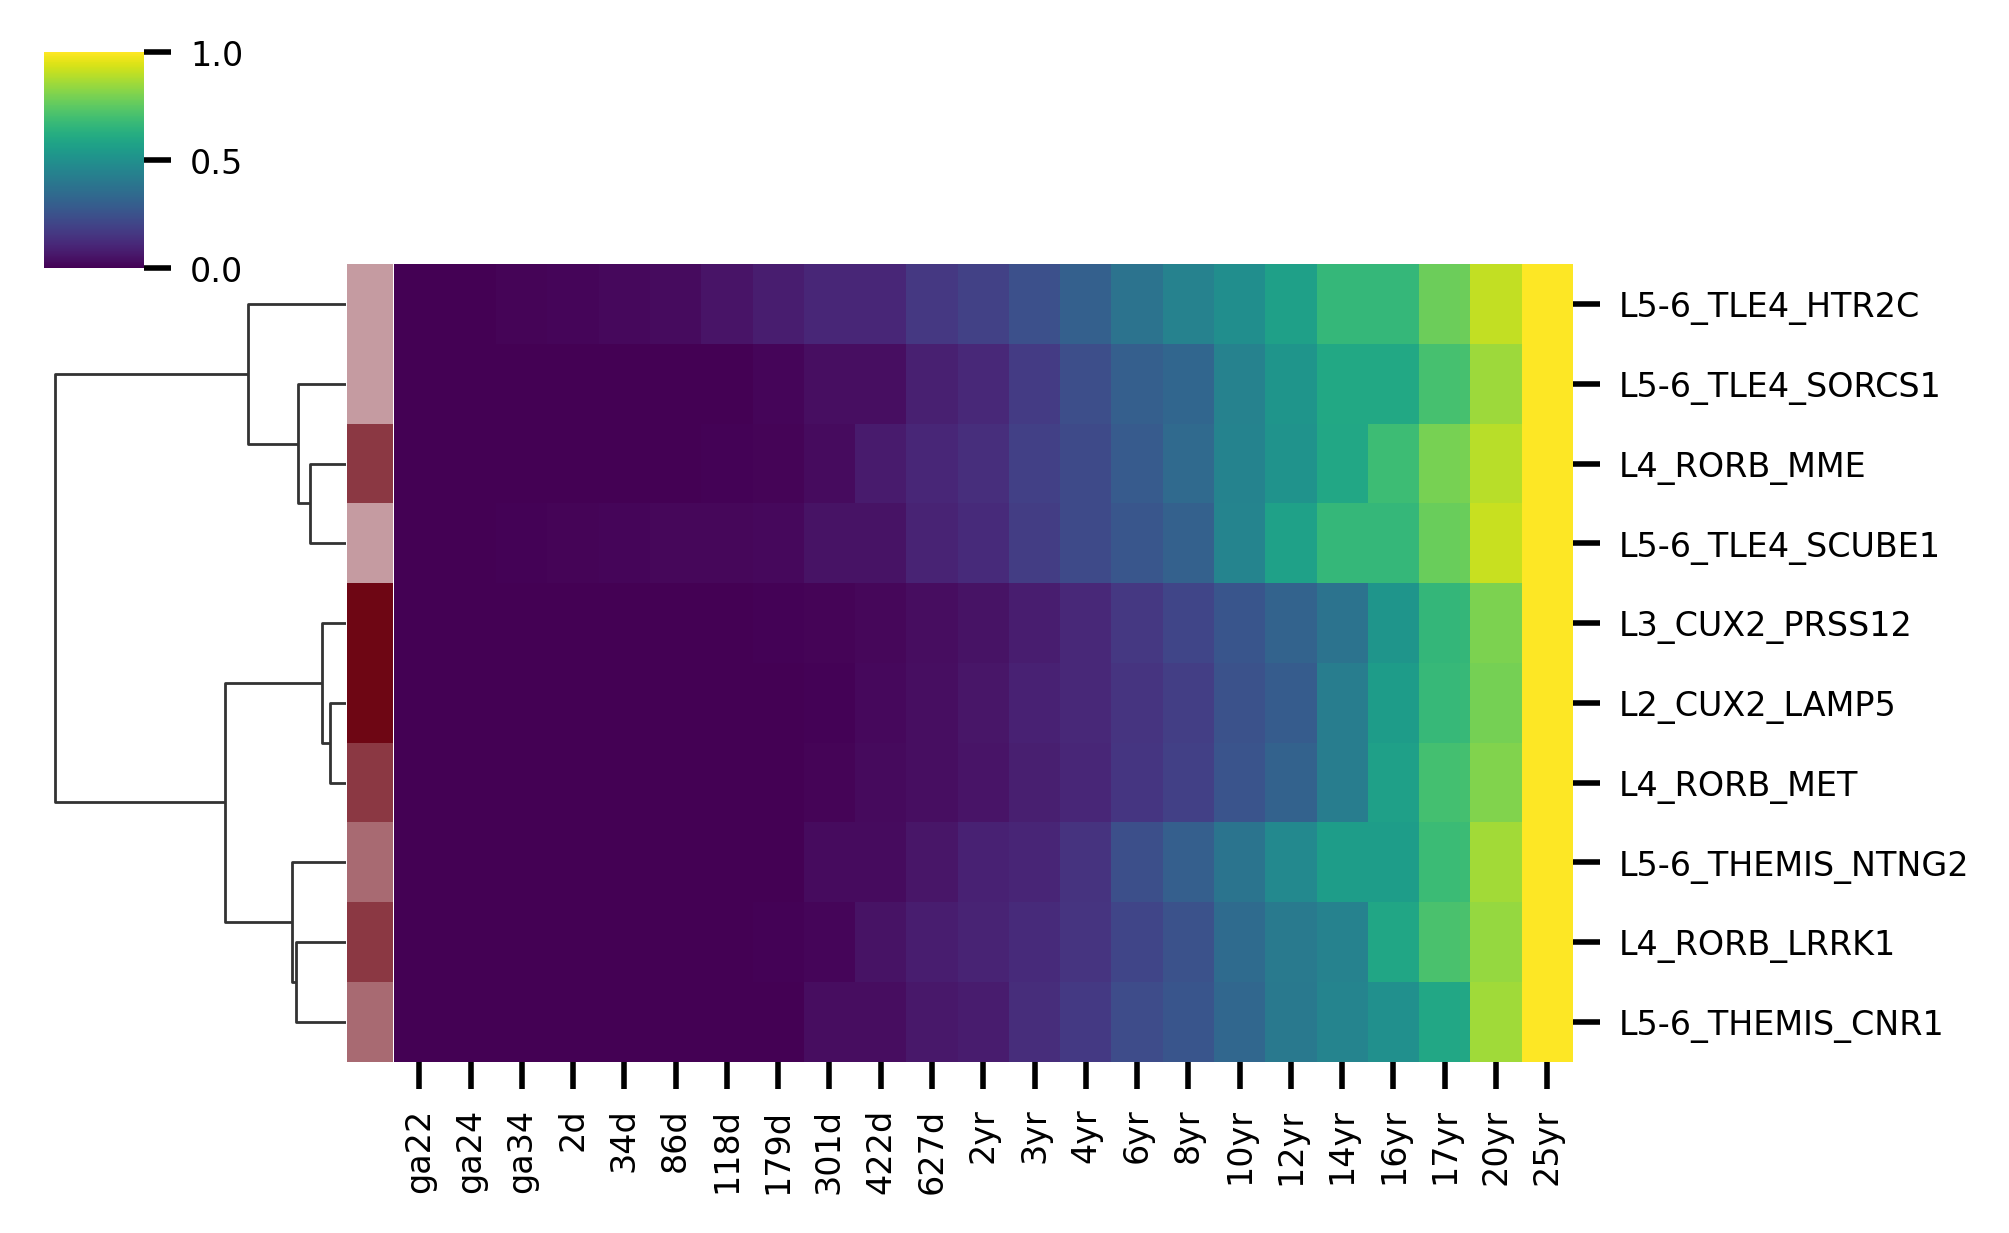

In [17]:
# col_cc = [wt_adata.uns['stage_colors_dict'][ii] for ii in wt_adta.uns['stage_order']]
row_cc = [color_dict[wt_df.loc[wt_df['sub_clust']==ii,'major_clust'].values[0]] for ii in plot_mat_order[:10]]

g = sns.clustermap( np.cumsum( tot_nn_df.loc[plot_mat_order[:10]], axis=1), cmap='viridis', linewidths=0.0, linecolor="grey", figsize=(5,3), 
                   row_cluster=True, col_cluster=False, standard_scale=0, row_colors=row_cc, method='ward')#, col_colors=col_cc)
fig = g.fig
fig.savefig( f"{fig_path}Nearest-Neighbor_Maturation_PNs_clustered.svg", format='svg', bbox_inches='tight')